In [1]:
import pandas as pd
import csv, os, random, torch, pickle, json
from scipy import sparse as sp
import numpy as np
import matplotlib.pyplot as plt
from mapping_data import reserved_addr, device_dict, additional_device, alter_device

In [2]:
PATH_IOT = f'./iot_CVSSscore.csv'
df_iot = pd.read_csv(PATH_IOT, encoding='cp949')
df_iot

,Unnamed: 0,분류,제품명,CVE,설명,비고,Reference,CVSS
0,0,Microcontroller,Raspberry Pi 3,CVE-2021-38759,NaN,NaN,VARIoT,9.8/10.0
1,1,Microcontroller,Raspberry Pi 3,CVE-2021-38545,NaN,NaN,VARIoT,5.9/4.3
2,2,Microcontroller,Raspberry Pi 3,CVE-2018-18068,NaN,NaN,VARIoT,9.8/10.0
3,3,Microcontroller,Raspberry Pi 3,CVE-2018-19860,NaN,NaN,VARIoT,8.8/5.8
4,4,Smartphone,Huawei Honor 10 Lite,CVE-2020-9069,NaN,NaN,VARIoT,6.5/3.3
...,...,...,...,...,...,...,...,...
343,343,4G LTE IoT,NaN,CVE-2022-29730,NaN,NaN,NaN,9.8/10.0
344,344,LoRaWAN,NaN,CVE-2023-26494,NaN,NaN,NaN,6.1/6.1
345,345,LoRaWAN,NaN,CVE-2022-34022,NaN,NaN,NaN,7.2
346,346,LoRaWAN,NaN,CVE-2022-34021,NaN,NaN,NaN,5.4


In [3]:
print(len(df_iot))
df_iot = df_iot[~(df_iot['CVSS'].isnull())]
print(len(df_iot))

348
260


In [4]:
reserved_addr = [i.lower() for i in reserved_addr]
reserved_addr

['01:00:5e:00:00:05',
 '01:00:5e:00:00:06',
 '01:00:5e:00:00:09',
 '01:00:5e:00:00:12',
 '01:00:5e:00:00:6b',
 '01:00:5e:00:00:fb',
 '01:00:5e:00:00:fc',
 '01:00:5e:00:01:01',
 '01:00:5e:00:01:81',
 '01:00:5e:00:01:82',
 '01:00:5e:00:01:83',
 '01:00:5e:00:01:84',
 '01:00:5e:7f:ff:fa',
 '01:00:5e:7f:ff:fb',
 '01:00:5e:7f:ff:fc',
 '01:00:5e:7f:ff:fd',
 '01:00:5e:00:00:e6',
 '01:00:5e:00:00:e7',
 '01:00:5e:00:00:e8',
 '01:00:5e:00:00:e9',
 '91:e0:f0:01:00:00']

In [5]:
PATH_TRAFFIC = f'./iot_dataset_alternative_cleaned_cvss.csv'
df_traffic = pd.read_csv(PATH_TRAFFIC)
df_traffic

,Unnamed: 0,Unnamed: 0.1,Packet ID,TIME,Size,eth.src,eth.dst,IP.src,IP.dst,IP.proto,port.src,port.dst,Src to Dst,hw.src,hw.dst,cvss.src,cvss.dst
0,0,0,1,1474552802,70,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228,"192.168.1.120, 46.105.38.79",Amazon Echo Dot,Eufy Homebase 2,7.6/9.8/9.0/4.2/1.9,6.5/7.4/6.1/8.8/7.1/5.8/9.8/10.0/7.5/7.5/7.7/5...
1,1,1,2,1474552802,66,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228,"192.168.1.120, 46.105.38.79",Amazon Echo Dot,Eufy Homebase 2,7.6/9.8/9.0/4.2/1.9,6.5/7.4/6.1/8.8/7.1/5.8/9.8/10.0/7.5/7.5/7.7/5...
2,4,4,6,1474552802,88,70:ee:50:18:34:43,14:cc:20:51:33:ea,192.168.1.241,192.168.1.1,17,61725,53,"192.168.1.241, 192.168.1.1",Netatmo Welcome,SmartThings Smart Hub,6.7/5.7/4.6/7.5/5.0,5.5/5.3/4.9/9.9/9.9/9.0/9.9/9.9/9.0
3,6,6,8,1474552802,54,14:cc:20:51:33:ea,d0:52:a8:00:67:5e,52.1.40.122,192.168.1.196,6,443,3063,"52.1.40.122, 192.168.1.196",Arlo Base station,Smart Things,8.1/9.3/9.8/10.0,7.8/4.2/7.8/3.3/4.6/5.5/5.5/2.1/7.5/7.5/5.0
4,7,7,11,1474552802,66,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228,"192.168.1.120, 46.105.38.79",Amazon Echo Dot,Asus router RT-N12,7.6/9.8/9.0/4.2/1.9,9.8/7.5/8.8/9.3/9.8/10.0/6.1/4.3/8.8/6.5/7.8/6...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433916,779157,802575,947065,1474639198,54,44:65:0d:56:cc:d3,14:cc:20:51:33:ea,192.168.1.240,205.251.242.52,6,40184,443,"192.168.1.240, 205.251.242.52",Amazon Echo,TP-Link TL-WR940N,3.3/4.3,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....
433917,779158,802576,947066,1474639198,95,44:65:0d:56:cc:d3,14:cc:20:51:33:ea,192.168.1.240,205.251.242.52,6,40184,443,"192.168.1.240, 205.251.242.52",Amazon Echo,TP-Link TL-WR940N,3.3/4.3,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....
433918,779160,802578,947068,1474639199,54,14:cc:20:51:33:ea,44:65:0d:56:cc:d3,205.251.242.52,192.168.1.240,6,443,40184,"205.251.242.52, 192.168.1.240",TP-Link TL-WR940N,Amazon Echo,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....,3.3/4.3
433919,779161,802579,947071,1474639199,156,30:8c:fb:2f:e4:b2,14:cc:20:51:33:ea,192.168.1.106,52.87.241.159,6,46330,443,"192.168.1.106, 52.87.241.159",Tapo C200 Camera,TP-Link TL-WR940N,4.6/9.8/9.8/10.0,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....


In [6]:
# 송신 unique IP, 수신 unique IP 개수
print(f'{len(df_traffic["IP.src"].unique()), len(df_traffic["IP.dst"].unique())}')

# 총 unique IP
total_ip_list = np.concatenate((df_traffic["IP.src"].unique(), df_traffic["IP.dst"].unique()))
print(len(np.unique(total_ip_list)))

# 총 MAC
total_mac_list = np.concatenate((df_traffic["eth.src"].unique(), df_traffic["eth.dst"].unique()))
print(len(np.unique(total_mac_list)))

(527, 177)
552
20


In [7]:
# Reserved Address 인 트래픽 제거
print(len(df_traffic))
df_traffic = df_traffic[~(df_traffic['eth.src'].isin(reserved_addr))]
print(len(df_traffic))
df_traffic = df_traffic[~(df_traffic['eth.dst'].isin(reserved_addr))]
print(len(df_traffic))

433921
433921
433921


In [8]:
# Device Unknown 트래픽 제거 (MAC : 01:00:5e:02:00:fc)
df_traffic = df_traffic[~(df_traffic['eth.dst']=='01:00:5e:02:00:fc')]
len(df_traffic)

433921

In [9]:
# CVSS mapping 파일 json 저장
hw_cvss_dict = {}
for idx, row in df_iot.iterrows():
    hw, cvss = row['제품명'], row['CVSS']
    if hw not in hw_cvss_dict:
        hw_cvss_dict[hw] = cvss
    else:
        hw_cvss_dict[hw] += ('/' + cvss)

In [10]:
with open('./hw_cvss_mapping.json') as f:
    hw_cvss_dict = json.load(f)

In [11]:
# cvss mapping 딕셔너리로 cvss 컬럼 추가
no_cvss_list = []
def temp_src(row):
    hw = row['hw.src']
    try:
        return hw_cvss_dict[hw]
    except:
        if hw not in no_cvss_list:
            no_cvss_list.append(hw)

In [12]:
no_cvss_list2 = []
def temp_dst(row):
    hw = row['hw.dst']
    try:
        return hw_cvss_dict[hw]
    except:
        if hw not in no_cvss_list:
            no_cvss_list2.append(hw)

In [13]:
#df_traffic.to_csv('./iot_dataset_filtered_cvss.csv', encoding='cp949')

In [14]:
alter_device

{'Triby Speaker': ['Amazon Echo Dot', 'Sonos One'],
 'TP-Link WiFi Router': ['Philips Hue Bridge',
  'TP-Link TL-WR940N',
  'Gigamon Network Tap G-TAP A-TX',
  'Cisco Catalyst 3850 24 switch',
  'Netgear Unmanaged Switch GS308',
  'Asus router RT-N12',
  'Arlo Base station',
  'Eufy Homebase 2',
  'Fibaro Home Center Lite',
  'SmartThings Smart Hub'],
 'Dropcam': ['Google Nest Cam Indoor',
  'Blink For Home',
  'HD Indoor/Outdoor IP Dome Camera HD838',
  'HD Indoor/Outdoor Mini IP Bullet Camera HD438',
  'Arlo Q Camera, Amcrest 2K Camera,Netatmo Indoor Camera',
  'Tapo C200 Camera',
  'Yi Indoor Camera (Yi Home Camera)',
  'Wyze V3 Camera',
  'TP-Link Day Night Cloud camera(NC220)',
  'Insteon Camera'],
 'Withings Smart Baby Monitor': ['Google Nest Cam Indoor',
  'Blink For Home',
  'HD Indoor/Outdoor IP Dome Camera HD838',
  'HD Indoor/Outdoor Mini IP Bullet Camera HD438',
  'Arlo Q Camera, Amcrest 2K Camera,Netatmo Indoor Camera',
  'Tapo C200 Camera',
  'Yi Indoor Camera (Yi Home Ca

In [15]:
# CVSS 없는 디바이스 유사한 것으로 대체
def update_alternative_device(row):
    alter_src, alter_dst = row['hw.src'], row['hw.dst']
    
    try: alter_src = random.choice(alter_device[alter_src])
    except KeyError: pass
    
    try: alter_dst = random.choice(alter_device[alter_dst])
    except KeyError: pass
    
    row['hw.src'], row['hw.dst'] = alter_src, alter_dst
    return row

In [16]:
df_traffic = df_traffic.apply(update_alternative_device, axis=1)

In [17]:
df_traffic[df_traffic['hw.src']=='Wyze V3 Camera']

,Unnamed: 0,Unnamed: 0.1,Packet ID,TIME,Size,eth.src,eth.dst,IP.src,IP.dst,IP.proto,port.src,port.dst,Src to Dst,hw.src,hw.dst,cvss.src,cvss.dst
62,84,93,113,1474552808,74,00:16:6c:ab:6b:88,ec:1a:59:83:28:11,192.168.1.249,192.168.1.193,6,49152,4981,"192.168.1.249, 192.168.1.193",Wyze V3 Camera,Belkin Wemo (Insight) switch,9.8/7.5/7.5/9.8/7.6/10.0,7.8/8.3/7.2
64,86,95,115,1474552808,66,00:16:6c:ab:6b:88,ec:1a:59:83:28:11,192.168.1.249,192.168.1.193,6,49152,4978,"192.168.1.249, 192.168.1.193",Wyze V3 Camera,Belkin Wemo switch,9.8/7.5/7.5/9.8/7.6/10.0,7.5/7.8/9.8/7.5
82,106,115,135,1474552808,66,00:16:6c:ab:6b:88,ec:1a:59:83:28:11,192.168.1.249,192.168.1.193,6,49152,4981,"192.168.1.249, 192.168.1.193",Wyze V3 Camera,Belkin Wemo (Insight) switch,9.8/7.5/7.5/9.8/7.6/10.0,7.8/8.3/7.2
96,127,136,156,1474552808,66,00:16:6c:ab:6b:88,ec:1a:59:83:28:11,192.168.1.249,192.168.1.193,6,49152,4982,"192.168.1.249, 192.168.1.193",Wyze V3 Camera,Belkin Wemo switch,9.8/7.5/7.5/9.8/7.6/10.0,7.5/7.8/9.8/7.5
218,255,264,286,1474552814,156,30:8c:fb:2f:e4:b2,14:cc:20:51:33:ea,192.168.1.106,52.87.241.159,6,46330,443,"192.168.1.106, 52.87.241.159",Wyze V3 Camera,Eufy Homebase 2,9.8/7.5/7.5/9.8/7.6/10.0,6.5/7.4/6.1/8.8/7.1/5.8/9.8/10.0/7.5/7.5/7.7/5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433609,778727,802122,946467,1474639112,66,00:24:e4:11:18:a8,14:cc:20:51:33:ea,192.168.1.166,212.83.131.101,6,37802,1935,"192.168.1.166, 212.83.131.101",Wyze V3 Camera,Arlo Base station,9.8/7.5/7.5/9.8/7.6/10.0,8.1/9.3/9.8/10.0
433648,778796,802191,946568,1474639132,66,00:16:6c:ab:6b:88,14:cc:20:51:33:ea,192.168.1.249,54.183.55.84,6,50623,5222,"192.168.1.249, 54.183.55.84",Wyze V3 Camera,Arlo Base station,9.8/7.5/7.5/9.8/7.6/10.0,8.1/9.3/9.8/10.0
433690,778862,802264,946685,1474639153,66,00:24:e4:11:18:a8,14:cc:20:51:33:ea,192.168.1.166,212.83.131.101,6,37802,1935,"192.168.1.166, 212.83.131.101",Wyze V3 Camera,SmartThings Smart Hub,9.8/7.5/7.5/9.8/7.6/10.0,5.5/5.3/4.9/9.9/9.9/9.0/9.9/9.9/9.0
433704,778882,802284,946712,1474639159,156,30:8c:fb:2f:e4:b2,14:cc:20:51:33:ea,192.168.1.106,52.87.241.159,6,46330,443,"192.168.1.106, 52.87.241.159",Wyze V3 Camera,Philips Hue Bridge,9.8/7.5/7.5/9.8/7.6/10.0,7.9/4.3/7.5/7.9/7.5/5.0


In [18]:
df_traffic['cvss.src'] = df_traffic.apply(temp_src, axis=1)
df_traffic['cvss.dst'] = df_traffic.apply(temp_dst, axis=1)

In [19]:
df_traffic

,Unnamed: 0,Unnamed: 0.1,Packet ID,TIME,Size,eth.src,eth.dst,IP.src,IP.dst,IP.proto,port.src,port.dst,Src to Dst,hw.src,hw.dst,cvss.src,cvss.dst
0,0,0,1,1474552802,70,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228,"192.168.1.120, 46.105.38.79",Amazon Echo Dot,Eufy Homebase 2,7.6/9.8/9.0/4.2/1.9,6.5/7.4/6.1/8.8/7.1/5.8/9.8/10.0/7.5/7.5/7.7/5...
1,1,1,2,1474552802,66,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228,"192.168.1.120, 46.105.38.79",Amazon Echo Dot,Eufy Homebase 2,7.6/9.8/9.0/4.2/1.9,6.5/7.4/6.1/8.8/7.1/5.8/9.8/10.0/7.5/7.5/7.7/5...
2,4,4,6,1474552802,88,70:ee:50:18:34:43,14:cc:20:51:33:ea,192.168.1.241,192.168.1.1,17,61725,53,"192.168.1.241, 192.168.1.1",Netatmo Welcome,SmartThings Smart Hub,6.7/5.7/4.6/7.5/5.0,5.5/5.3/4.9/9.9/9.9/9.0/9.9/9.9/9.0
3,6,6,8,1474552802,54,14:cc:20:51:33:ea,d0:52:a8:00:67:5e,52.1.40.122,192.168.1.196,6,443,3063,"52.1.40.122, 192.168.1.196",Arlo Base station,Smart Things,8.1/9.3/9.8/10.0,7.8/4.2/7.8/3.3/4.6/5.5/5.5/2.1/7.5/7.5/5.0
4,7,7,11,1474552802,66,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228,"192.168.1.120, 46.105.38.79",Amazon Echo Dot,Asus router RT-N12,7.6/9.8/9.0/4.2/1.9,9.8/7.5/8.8/9.3/9.8/10.0/6.1/4.3/8.8/6.5/7.8/6...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433916,779157,802575,947065,1474639198,54,44:65:0d:56:cc:d3,14:cc:20:51:33:ea,192.168.1.240,205.251.242.52,6,40184,443,"192.168.1.240, 205.251.242.52",Amazon Echo,TP-Link TL-WR940N,3.3/4.3,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....
433917,779158,802576,947066,1474639198,95,44:65:0d:56:cc:d3,14:cc:20:51:33:ea,192.168.1.240,205.251.242.52,6,40184,443,"192.168.1.240, 205.251.242.52",Amazon Echo,TP-Link TL-WR940N,3.3/4.3,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....
433918,779160,802578,947068,1474639199,54,14:cc:20:51:33:ea,44:65:0d:56:cc:d3,205.251.242.52,192.168.1.240,6,443,40184,"205.251.242.52, 192.168.1.240",TP-Link TL-WR940N,Amazon Echo,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....,3.3/4.3
433919,779161,802579,947071,1474639199,156,30:8c:fb:2f:e4:b2,14:cc:20:51:33:ea,192.168.1.106,52.87.241.159,6,46330,443,"192.168.1.106, 52.87.241.159",Tapo C200 Camera,TP-Link TL-WR940N,4.6/9.8/9.8/10.0,9.8/7.5/7.5/7.7/7.7/7.7/9.9/7.5/8.8/8.1/8.1/7....


In [20]:
#df_traffic.to_csv(f'iot_dataset_alternative_cvss.csv')

In [21]:
# CVSS 결측치 행 제거
alternative_cvss = pd.read_csv(f'iot_dataset_alternative_cvss.csv')
df_cleaned = alternative_cvss.dropna()
print(df_cleaned)

        Unnamed: 0  Packet ID        TIME  Size            eth.src  \
0                0          1  1474552802    70  18:b7:9e:02:20:44   
1                1          2  1474552802    66  18:b7:9e:02:20:44   
4                4          6  1474552802    88  70:ee:50:18:34:43   
6                6          8  1474552802    54  14:cc:20:51:33:ea   
7                7         11  1474552802    66  18:b7:9e:02:20:44   
...            ...        ...         ...   ...                ...   
779157      802575     947065  1474639198    54  44:65:0d:56:cc:d3   
779158      802576     947066  1474639198    95  44:65:0d:56:cc:d3   
779160      802578     947068  1474639199    54  14:cc:20:51:33:ea   
779161      802579     947071  1474639199   156  30:8c:fb:2f:e4:b2   
779162      802580     947072  1474639199    66  14:cc:20:51:33:ea   

                  eth.dst          IP.src          IP.dst  IP.proto  port.src  \
0       14:cc:20:51:33:ea   192.168.1.120    46.105.38.79         6     40234 

In [22]:
#df_cleaned.to_csv(f'iot_dataset_alternative_cleaned_cvss.csv')

In [23]:
conntection_list = []
for idx, id in df_cleaned.iterrows():
    ip_list = id['Src to Dst'].split(',')
    ip_tuple = tuple([str(i) for i in ip_list])
    conntection_list.append(ip_tuple)
conntection_list

[('192.168.1.120', ' 46.105.38.79'),
 ('192.168.1.120', ' 46.105.38.79'),
 ('192.168.1.241', ' 192.168.1.1'),
 ('52.1.40.122', ' 192.168.1.196'),
 ('192.168.1.120', ' 46.105.38.79'),
 ('52.8.241.183', ' 192.168.1.241'),
 ('192.168.1.1', ' 192.168.1.241'),
 ('192.168.1.196', ' 52.1.40.122'),
 ('192.168.1.196', ' 52.1.40.122'),
 ('192.168.1.106', ' 52.87.241.159'),
 ('212.83.131.101', ' 192.168.1.166'),
 ('192.168.1.166', ' 212.83.131.101'),
 ('52.87.241.159', ' 192.168.1.106'),
 ('192.168.1.166', ' 212.83.131.101'),
 ('192.168.1.106', ' 52.87.241.159'),
 ('52.87.241.159', ' 192.168.1.106'),
 ('192.168.1.240', ' 23.23.189.20'),
 ('192.168.1.193', ' 192.168.1.223'),
 ('192.168.1.223', ' 192.168.1.193'),
 ('192.168.1.193', ' 192.168.1.223'),
 ('192.168.1.193', ' 192.168.1.223'),
 ('192.168.1.223', ' 192.168.1.193'),
 ('192.168.1.223', ' 192.168.1.193'),
 ('192.168.1.223', ' 192.168.1.193'),
 ('192.168.1.193', ' 192.168.1.223'),
 ('192.168.1.193', ' 192.168.1.223'),
 ('192.168.1.223', ' 192

In [24]:
len(conntection_list)

433921

In [25]:
import statistics
# 최대 CVSS값 딕셔너리 만들기
cvss_dict = {}
result_list = []
for idx, id in df_cleaned.iterrows():
    ip_list = id['Src to Dst'].split(',')
    ip_tuple = tuple([str(i) for i in ip_list])

    if ip_tuple[0] not in cvss_dict:
        cvss_dict[ip_tuple[0]] = statistics.mean(list(map(float, id['cvss.src'].split('/'))))
    
    if ip_tuple[1] not in cvss_dict:
        cvss_dict[ip_tuple[1]] = statistics.mean(list(map(float, id['cvss.dst'].split('/'))))
        
cvss_dict

{'192.168.1.120': 6.5,
 ' 46.105.38.79': 8.503030303030304,
 '192.168.1.241': 5.9,
 ' 192.168.1.1': 8.144444444444444,
 '52.1.40.122': 9.3,
 ' 192.168.1.196': 5.527272727272727,
 '52.8.241.183': 8.042857142857143,
 ' 192.168.1.241': 5.9,
 '192.168.1.1': 6.683333333333334,
 '192.168.1.196': 5.527272727272727,
 ' 52.1.40.122': 8.144444444444444,
 '192.168.1.106': 7.862500000000001,
 ' 52.87.241.159': 8.503030303030304,
 '212.83.131.101': 8.042857142857143,
 ' 192.168.1.166': 7.862500000000001,
 '192.168.1.166': 6.980555555555555,
 ' 212.83.131.101': 8.144444444444444,
 '52.87.241.159': 8.144444444444444,
 ' 192.168.1.106': 7.072222222222222,
 '192.168.1.240': 3.8,
 ' 23.23.189.20': 7.853571428571429,
 '192.168.1.193': 8.15,
 ' 192.168.1.223': 8.15,
 '192.168.1.223': 8.15,
 ' 192.168.1.193': 7.766666666666667,
 '192.168.1.249': 6.980555555555555,
 ' 192.168.1.249': 8.65,
 '46.105.38.79': 6.807142857142857,
 ' 192.168.1.239': 7.853571428571429,
 ' 52.8.241.183': 7.853571428571429,
 '54.239

In [26]:
cvss_dict_cleaned = {key.strip(): value for key, value in cvss_dict.items()}
cvss_dict_cleaned

{'192.168.1.120': 6.5,
 '46.105.38.79': 6.807142857142857,
 '192.168.1.241': 5.9,
 '192.168.1.1': 6.683333333333334,
 '52.1.40.122': 8.144444444444444,
 '192.168.1.196': 5.527272727272727,
 '52.8.241.183': 7.853571428571429,
 '192.168.1.106': 7.072222222222222,
 '52.87.241.159': 8.144444444444444,
 '212.83.131.101': 8.144444444444444,
 '192.168.1.166': 6.980555555555555,
 '192.168.1.240': 3.8,
 '23.23.189.20': 8.144444444444444,
 '192.168.1.193': 7.766666666666667,
 '192.168.1.223': 8.15,
 '192.168.1.249': 8.65,
 '192.168.1.239': 7.853571428571429,
 '54.239.29.231': 7.258333333333334,
 '54.183.55.84': 8.503030303030304,
 '67.18.187.111': 6.683333333333334,
 '129.250.35.250': 8.042857142857143,
 '104.154.46.102': 7.258333333333334,
 '121.0.0.42': 6.683333333333334,
 '15.72.162.53': 7.258333333333334,
 '192.168.1.236': 6.684,
 '207.171.178.6': 7.258333333333334,
 '111.206.200.2': 8.042857142857143,
 '89.30.121.150': 8.042857142857143,
 '174.129.217.97': 8.042857142857143,
 '192.168.1.177

In [27]:
import networkx as nx
graph = nx.Graph()
#graph.add_nodes_from(total_ip_list)
for ip in total_ip_list:
    graph.add_node(ip, weight=cvss_dict_cleaned[ip])

In [28]:
graph.add_edges_from(conntection_list)

In [ ]:


#plt.figure(figsize=(26, 20))
plt.margins(x=0.1, y=0.02)

pos = nx.kamada_kawai_layout(graph)

nx.draw_networkx_nodes(
    graph, pos, node_shape='h', node_size=200, cmap=plt.cm.rainbow, alpha=0.9
                    )
nx.draw_networkx_edges(
    graph, pos, widbth=1
    
    
    
    
    
)
nx.draw_networkx_labels(
    graph, pos, font_family='sans-serif', font_color='black', font_size=7
)
plt.axis('off')
plt.show()

: 

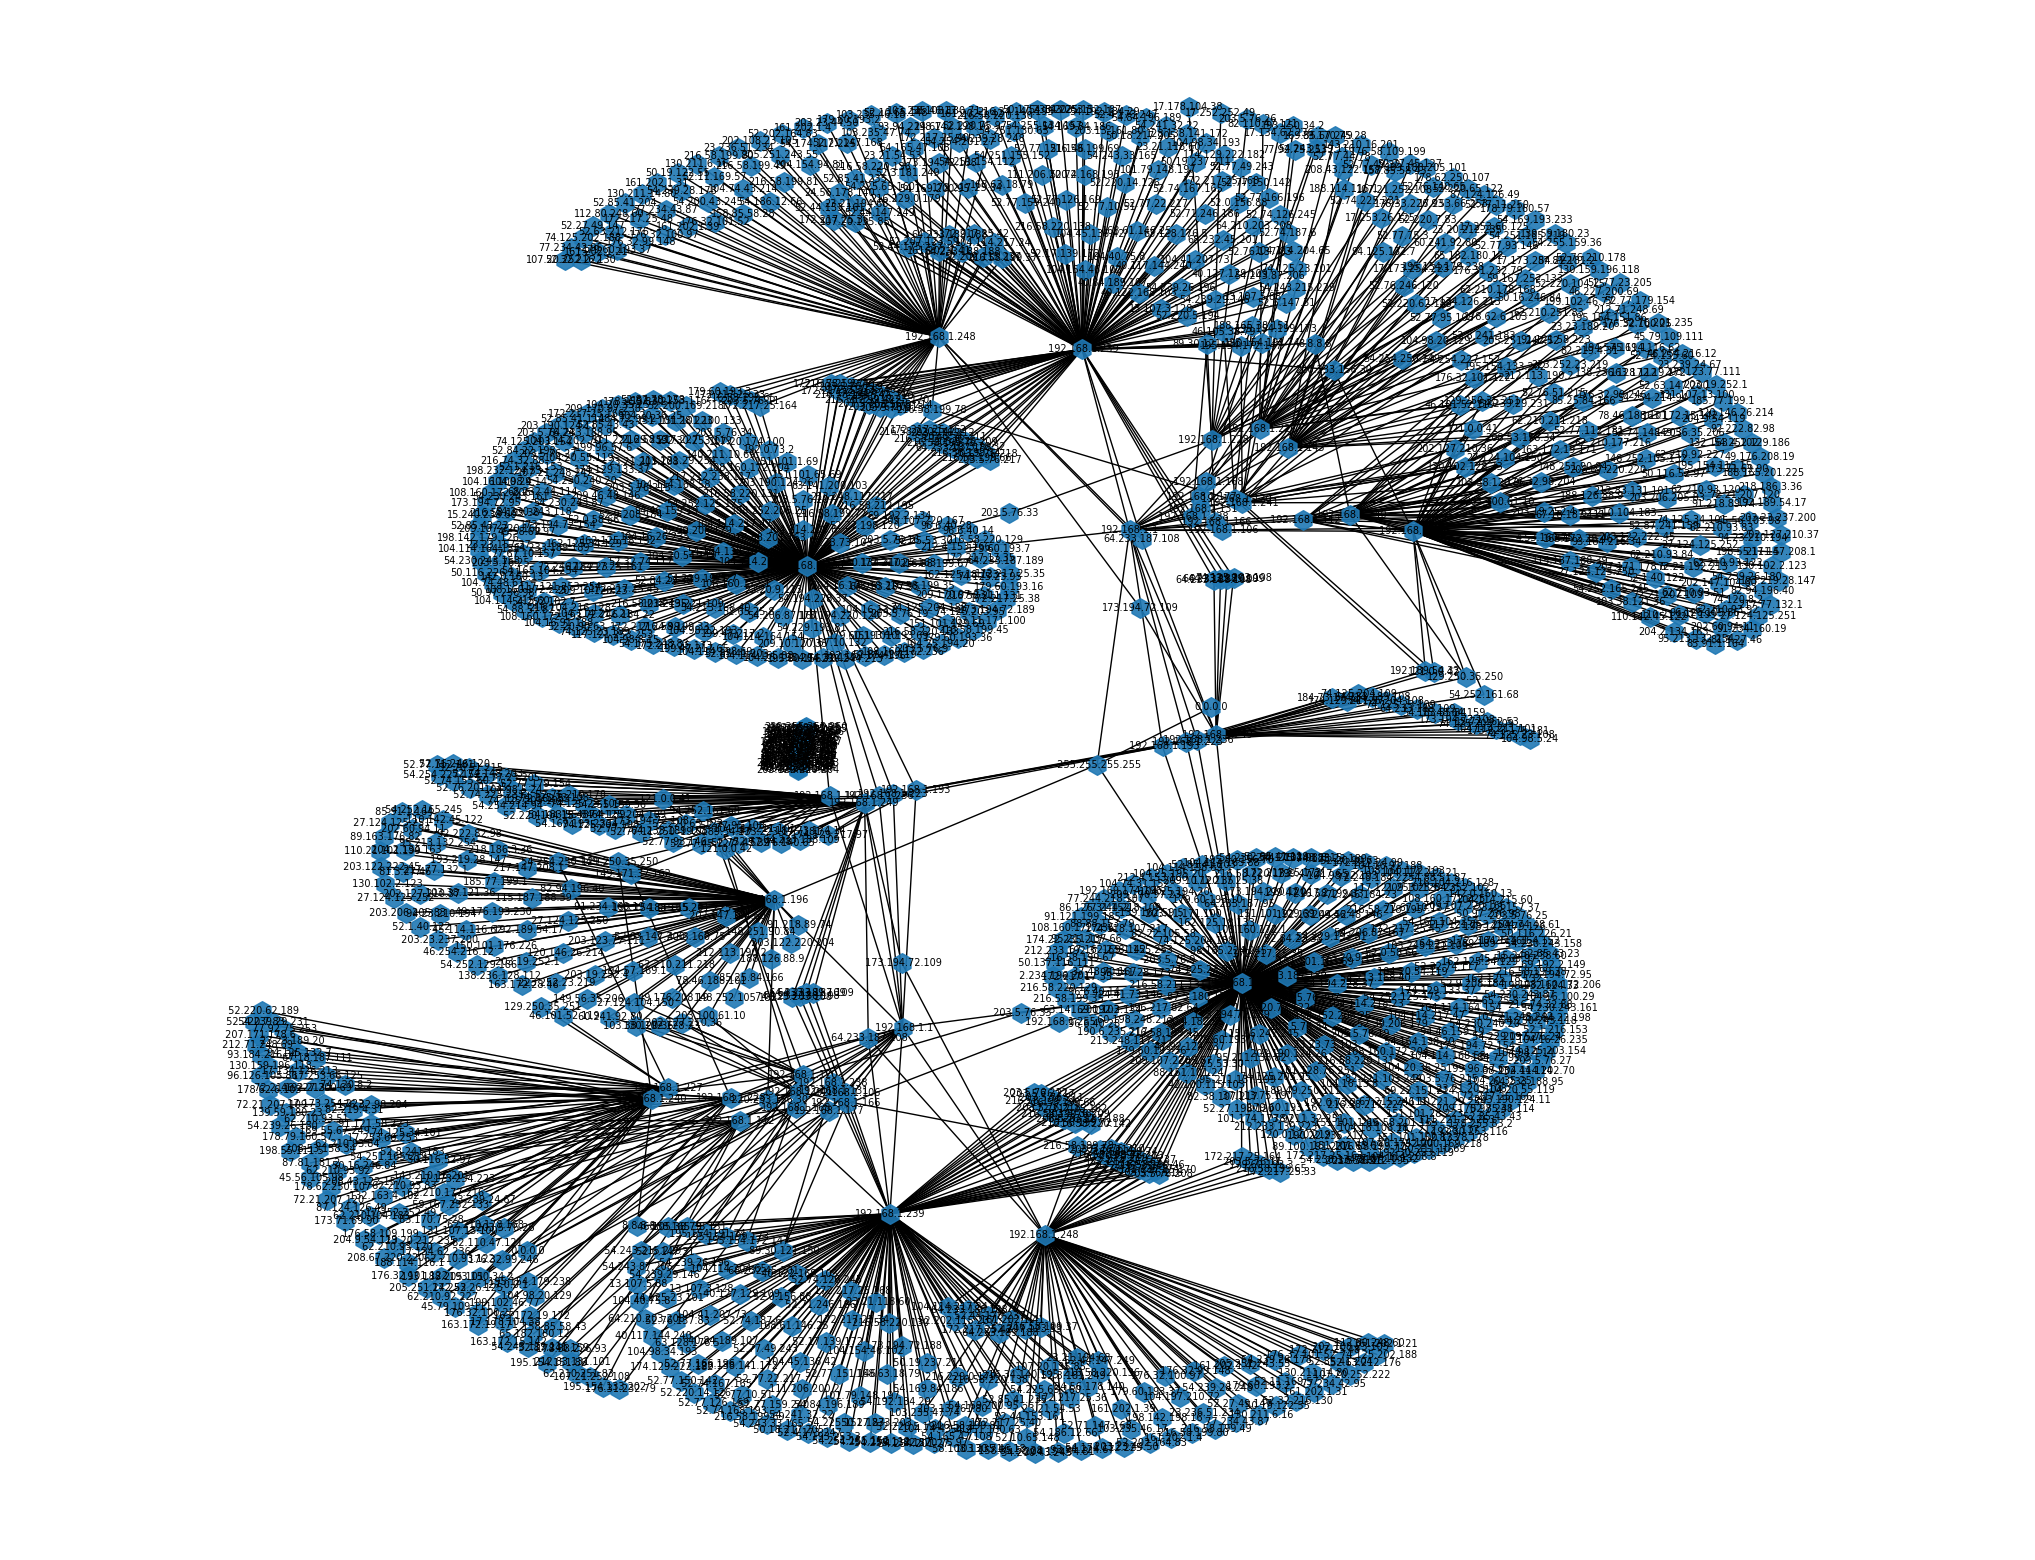

In [95]:
graph = nx.Graph()
graph.add_nodes_from(total_ip_list)
graph.add_edges_from(conntection_list)

plt.figure(figsize=(26, 20))
plt.margins(x=0.1, y=0.02)

pos = nx.kamada_kawai_layout(graph)

nx.draw_networkx_nodes(
    graph, pos, node_shape='h', node_size=200, cmap=plt.cm.rainbow, alpha=0.9
                    )
nx.draw_networkx_edges(
    graph, pos, width=1
)
nx.draw_networkx_labels(
    graph, pos, font_family='sans-serif', font_color='black', font_size=7
)
plt.axis('off')
plt.show()

In [ ]:
def iot_graph_generator(num_nodes, num_edges, in_features):
    # 방향 그래프 생성
    graph = nx.Graph()

    # 노드 추가
    nodes = range(num_nodes)
    graph.add_nodes_from(nodes)

    # 노드에 가중치 할당 및 노드 특징 벡터 생성
    x = torch.zeros(num_nodes, in_features)
    for node in graph.nodes:
        weight = random.uniform(0, 1)
        graph.nodes[node]['weight'] = weight
        x[node] = weight
    connected_nodes = set()
    start_node = random.choice(nodes)
    connected_nodes.add(start_node)
    for node in nodes:
        if node != start_node:
            graph.add_edge(start_node, node)
            connected_nodes.add(node)

    # 추가적인 랜덤 에지를 생성하여 num_edges를 충족
    additional_edges = num_edges - len(graph.edges)
    for _ in range(additional_edges):
        # 임의의 출발 노드와 도착 노드 선택
        source = random.choice(nodes)
        target = random.choice(nodes)
        
        if source == target or graph.has_edge(source, target):
            continue

        # 에지 추가
        graph.add_edge(source, target)

        # Generate v_prev tensor
    j = random.randint(0, num_nodes-1)

    adj_matrix = nx.adjacency_matrix(graph)
    adj_matrix_original = torch.Tensor(adj_matrix.todense())
    adj_matrix = adj_matrix + sp.eye(adj_matrix.shape[0]) # Add self-loop
    adj_tensor = torch.Tensor(adj_matrix.todense())
    adj_tensor = adj_tensor.unsqueeze(2)
    return graph, x, adj_tensor, adj_matrix_original, j